In [1]:
import tensorflow as tf
import tensorflow.contrib.timeseries as ts
from tensorflow.contrib.timeseries.python.timeseries import model as ts_model
from tensorflow.contrib.timeseries.python.timeseries import estimators as ts_estimators
from tensorflow.contrib.timeseries.python.timeseries import NumpyReader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 1.5})
%matplotlib inline

/Users/qp19/anaconda2/envs/oreillytf/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#Read the data
train = pd.read_csv('data/AirPassengersTrain.csv')
test = pd.read_csv('data/AirPassengersTest.csv')

In [3]:
#Transform the data into numpy vectors to feed into TF 
x = train.as_matrix(columns=train.columns[0:1])
y = train.as_matrix(columns=train.columns[1:2])
x = x.reshape((120,))

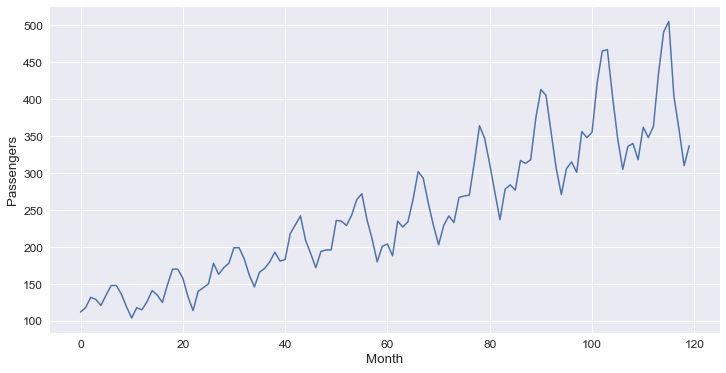

In [4]:
plt.figure(figsize=(12,6))
plt.xlabel('Month')
plt.ylabel('Passengers')
_ = plt.plot(x, y)

In [8]:
#Set the data 
data = {
    ts.TrainEvalFeatures.TIMES: x,
    ts.TrainEvalFeatures.VALUES: y
}

reader = NumpyReader(data)

train_input_fn = ts.RandomWindowInputFn(
        reader, batch_size=4, window_size=24)

In [9]:
train_input_fn

In [27]:
class _LSTMModel(ts_model.SequentialTimeSeriesModel):
  """A time series model-building example using an RNNCell."""

  def __init__(self, num_units, num_features, dtype=tf.float32):
    """Initialize/configure the model object.
    Note that we do not start graph building here. Rather, this object is a
    configurable factory for TensorFlow graphs which are run by an Estimator.
    Args:
      num_units: The number of units in the model's LSTMCell.
      num_features: The dimensionality of the time series (features per
        timestep).
      dtype: The floating point data type to use.
    """
    super(_LSTMModel, self).__init__(
        # Pre-register the metrics we'll be outputting (just a mean here).
        train_output_names=["mean"],
        predict_output_names=["mean"],
        num_features=num_features,
        dtype=dtype)
    self._num_units = num_units
    # Filled in by initialize_graph()
    self._lstm_cell = None
    self._lstm_cell_run = None
    self._predict_from_lstm_output = None

  def initialize_graph(self, input_statistics):
    """Save templates for components, which can then be used repeatedly.
    This method is called every time a new graph is created. It's safe to start
    adding ops to the current default graph here, but the graph should be
    constructed from scratch.
    Args:
      input_statistics: A math_utils.InputStatistics object.
    """
    super(_LSTMModel, self).initialize_graph(input_statistics=input_statistics)
    self._lstm_cell = tf.nn.rnn_cell.LSTMCell(num_units=self._num_units)
    # Create templates so we don't have to worry about variable reuse.
    self._lstm_cell_run = tf.make_template(
        name_="lstm_cell",
        func_=self._lstm_cell,
        create_scope_now_=True)
    # Transforms LSTM output into mean predictions.
    self._predict_from_lstm_output = tf.make_template(
        name_="predict_from_lstm_output",
        func_=lambda inputs: tf.layers.dense(inputs=inputs, units=self.num_features),
        create_scope_now_=True)

  def get_start_state(self):
    """Return initial state for the time series model."""
    return (
        # Keeps track of the time associated with this state for error checking.
        tf.zeros([], dtype=tf.int64),
        # The previous observation or prediction.
        tf.zeros([self.num_features], dtype=self.dtype),
        # The state of the RNNCell (batch dimension removed since this parent
        # class will broadcast).
        [tf.squeeze(state_element, axis=0)
         for state_element
         in self._lstm_cell.zero_state(batch_size=1, dtype=self.dtype)])

  def _transform(self, data):
    """Normalize data based on input statistics to encourage stable training."""
    mean, variance = self._input_statistics.overall_feature_moments
    return (data - mean) / variance

  def _de_transform(self, data):
    """Transform data back to the input scale."""
    mean, variance = self._input_statistics.overall_feature_moments
    return data * variance + mean

  def _filtering_step(self, current_times, current_values, state, predictions):
    """Update model state based on observations.
    Note that we don't do much here aside from computing a loss. In this case
    it's easier to update the RNN state in _prediction_step, since that covers
    running the RNN both on observations (from this method) and our own
    predictions. This distinction can be important for probabilistic models,
    where repeatedly predicting without filtering should lead to low-confidence
    predictions.
    Args:
      current_times: A [batch size] integer Tensor.
      current_values: A [batch size, self.num_features] floating point Tensor
        with new observations.
      state: The model's state tuple.
      predictions: The output of the previous `_prediction_step`.
    Returns:
      A tuple of new state and a predictions dictionary updated to include a
      loss (note that we could also return other measures of goodness of fit,
      although only "loss" will be optimized).
    """
    state_from_time, prediction, lstm_state = state
    with tf.control_dependencies(
            [tf.assert_equal(current_times, state_from_time)]):
      transformed_values = self._transform(current_values)
      # Use mean squared error across features for the loss.
      predictions["loss"] = tf.reduce_mean(
          (prediction - transformed_values) ** 2, axis=-1)
      # Keep track of the new observation in model state. It won't be run
      # through the LSTM until the next _imputation_step.
      new_state_tuple = (current_times, transformed_values, lstm_state)
    return (new_state_tuple, predictions)

  def _prediction_step(self, current_times, state):
    """Advance the RNN state using a previous observation or prediction."""
    _, previous_observation_or_prediction, lstm_state = state
    lstm_output, new_lstm_state = self._lstm_cell_run(
        inputs=previous_observation_or_prediction, state=lstm_state)
    next_prediction = self._predict_from_lstm_output(lstm_output)
    new_state_tuple = (current_times, next_prediction, new_lstm_state)
    return new_state_tuple, {"mean": self._de_transform(next_prediction)}

  def _imputation_step(self, current_times, state):
    """Advance model state across a gap."""
    # Does not do anything special if we're jumping across a gap. More advanced
    # models, especially probabilistic ones, would want a special case that
    # depends on the gap size.
    return state

  def _exogenous_input_step(
          self, current_times, current_exogenous_regressors, state):
    """Update model state based on exogenous regressors."""
    raise NotImplementedError(
        "Exogenous inputs are not implemented for this example.")

In [28]:
estimator = ts_estimators.TimeSeriesRegressor(
      model=_LSTMModel(num_features=1, num_units=128),
      optimizer=tf.train.AdamOptimizer(0.001))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x109564e50>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/var/folders/0x/dj_gdwxs50j09mfgw7kqkg243np59x/T/tmp23Xapo', '_global_id_in_cluster': 0, '_save_summary_steps': 100}


In [29]:
estimator.train(input_fn=train_input_fn, steps=2000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/0x/dj_gdwxs50j09mfgw7kqkg243np59x/T/tmp23Xapo/model.ckpt.
INFO:tensorflow:loss = 0.00014000265, step = 1
INFO:tensorflow:global_step/sec: 61.3483
INFO:tensorflow:loss = 5.274315e-05, step = 101 (1.632 sec)
INFO:tensorflow:global_step/sec: 70.7678
INFO:tensorflow:loss = 2.7250806e-05, step = 201 (1.413 sec)
INFO:tensorflow:global_step/sec: 72.7722
INFO:tensorflow:loss = 1.9737849e-05, step = 301 (1.376 sec)
INFO:tensorflow:global_step/sec: 72.2945
INFO:tensorflow:loss = 1.8826684e-05, step = 401 (1.381 sec)
INFO:tensorflow:global_step/sec: 76.2461
INFO:tensorflow:loss = 1.8016442e-05, step = 501 (1.312 sec)
INFO:tensorflow:global_step/sec: 72.7241
INFO:tensorflow:loss = 1.4757054e-05, step = 601 

In [30]:
eval_input_fn = ts.WholeDatasetInputFn(reader)

In [31]:
evaluation = estimator.evaluate(input_fn=eval_input_fn, steps=1)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-07-26-05:19:52
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/0x/dj_gdwxs50j09mfgw7kqkg243np59x/T/tmp23Xapo/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2018-07-26-05:19:52
INFO:tensorflow:Saving dict for global step 2000: global_step = 2000, loss = 1.0114999e-05, mean = [[[214.3264  ]
  [113.47269 ]
  [142.46005 ]
  [150.74438 ]
  [149.60834 ]
  [135.92511 ]
  [149.32744 ]
  [163.87416 ]
  [168.02847 ]
  [153.42911 ]
  [126.84514 ]
  [101.65056 ]
  [113.53912 ]
  [110.96649 ]
  [133.29092 ]
  [153.16907 ]
  [148.54845 ]
  [139.57123 ]
  [164.27661 ]
  [178.51163 ]
  [171.38693 ]
  [153.21786 ]
  [126.920845]
  [115.61931 ]
  [152.08557 ]
  [154.9958  ]
  [160.66638 ]
  [187.41609 ]
  [170.8798  ]
  [19

In [32]:
def compute_rmse(a, b):
    rmse =  np.sqrt(np.sum(np.square(a - b)) / len(a))
    return round(rmse,5)

def compute_mae(a, b):
    mae =  np.sqrt(np.sum(np.abs(a - b)) / len(a))
    return round(mae,5)

In [33]:
x_current = evaluation['times'][0]
y_current_actual = evaluation['observed'][0].reshape(-1)
y_current_estimated = evaluation['mean'][0].reshape(-1)

rmse = compute_rmse(y_current_actual, y_current_estimated)
mae = compute_mae(y_current_actual, y_current_estimated)
print("Evaluation RMSE {}".format(rmse))
print("Evaluation MAE {}".format(mae))

Evaluation RMSE 21.65314
Evaluation MAE 4.0157


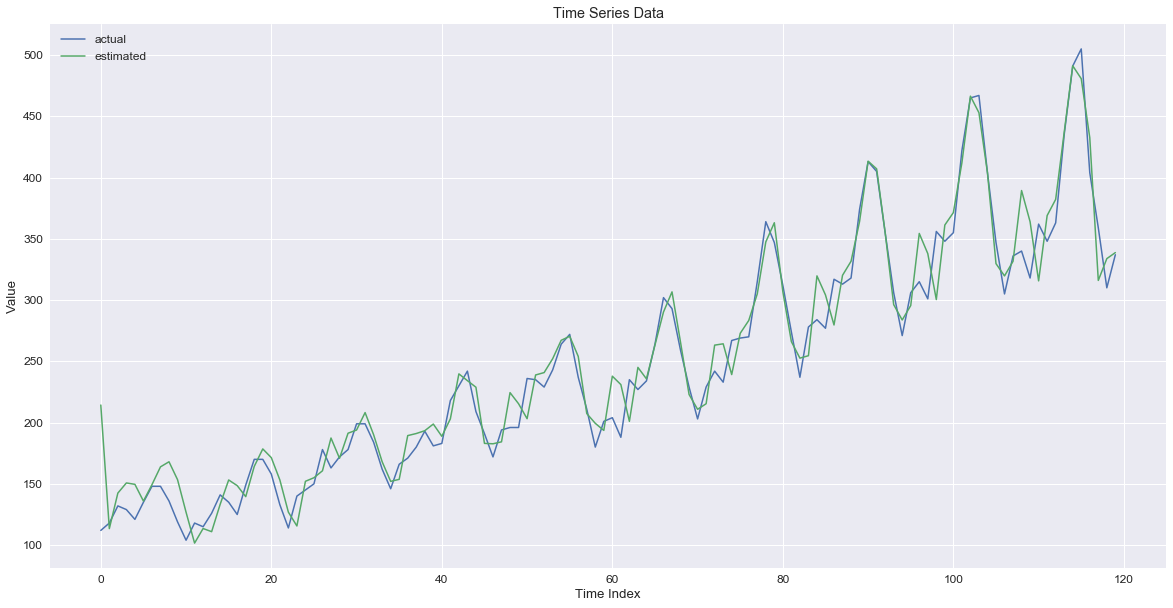

In [34]:
plt.figure(figsize=(20, 10))

plt.title("Time Series Data")
plt.plot(x_current, y_current_actual, label='actual')
plt.plot(x_current, y_current_estimated, label='estimated')
plt.xlabel("Time Index")
plt.ylabel("Value")
plt.legend(loc=2)
plt.show()

In [35]:
#Transform the test data into numpy vectors to feed into TF 
x_test = test.as_matrix(columns=train.columns[0:1])
y_test = test.as_matrix(columns=train.columns[1:2])
x_test = x_test.reshape((24,))

In [36]:
evaluation = estimator.evaluate(input_fn=eval_input_fn, steps=1)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-07-26-05:20:12
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/0x/dj_gdwxs50j09mfgw7kqkg243np59x/T/tmp23Xapo/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2018-07-26-05:20:12
INFO:tensorflow:Saving dict for global step 2000: global_step = 2000, loss = 1.0114999e-05, mean = [[[214.3264  ]
  [113.47269 ]
  [142.46005 ]
  [150.74438 ]
  [149.60834 ]
  [135.92511 ]
  [149.32744 ]
  [163.87416 ]
  [168.02847 ]
  [153.42911 ]
  [126.84514 ]
  [101.65056 ]
  [113.53912 ]
  [110.96649 ]
  [133.29092 ]
  [153.16907 ]
  [148.54845 ]
  [139.57123 ]
  [164.27661 ]
  [178.51163 ]
  [171.38693 ]
  [153.21786 ]
  [126.920845]
  [115.61931 ]
  [152.08557 ]
  [154.9958  ]
  [160.66638 ]
  [187.41609 ]
  [170.8798  ]
  [19

In [37]:
forecasts = estimator.predict(input_fn=ts.predict_continuation_input_fn(evaluation, steps=24))

In [38]:
forecasts = tuple(forecasts)[0]

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/0x/dj_gdwxs50j09mfgw7kqkg243np59x/T/tmp23Xapo/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [39]:
forecasts['mean']

array([[395.1181 ],
       [417.0675 ],
       [398.5082 ],
       [384.34344],
       [422.89642],
       [508.24384],
       [574.1986 ],
       [554.2777 ],
       [450.9005 ],
       [341.91376],
       [312.28494],
       [374.4942 ],
       [459.2025 ],
       [487.893  ],
       [452.42517],
       [421.53546],
       [466.76242],
       [578.21063],
       [659.15845],
       [617.5719 ],
       [465.0331 ],
       [318.9124 ],
       [297.54688],
       [406.68738]], dtype=float32)

In [40]:
y_forecast = forecasts['mean']
rmse =  compute_rmse(y_test, y_forecast)
mae =  compute_mae(y_test, y_forecast)



In [41]:
rmse

52.18257

In [42]:
mae

6.35343

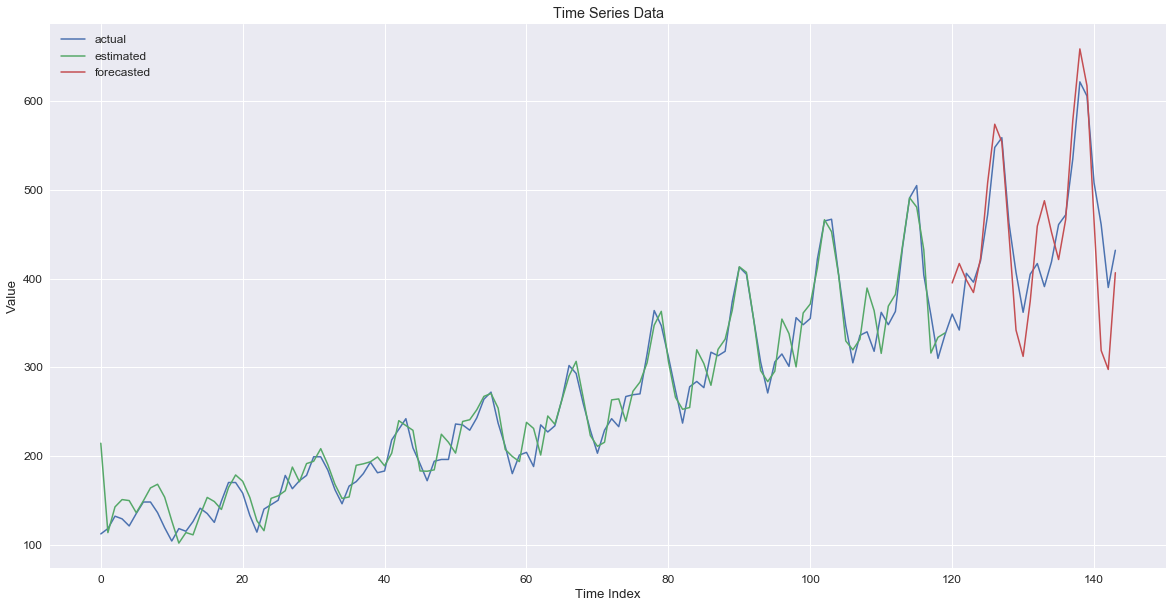

In [43]:
x_all = np.concatenate( (x_current, x_test) , axis=0)
y_actual_all = np.concatenate((y_current_actual, y_test.reshape((24,))), axis=0)

plt.close('all')
plt.figure(figsize=(20, 10))

plt.title("Time Series Data")
plt.plot(x_all, y_actual_all, label='actual')
plt.plot(x_current, y_current_estimated, label='estimated')
plt.plot(x_test, y_forecast, label='forecasted')
plt.xlabel("Time Index")
plt.ylabel("Value")
plt.legend(loc=2)
plt.show()